# Modeling spike data with `multidms.jaxmodels`

In [135]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Papermill params

In [136]:
replicate = "lib_1"
func_score_type = "tight_bottle"
# func_score_type = "observed_phenotype"
do_truncate_nonsense = True
output_dir = 'simulations_output'

reference = 'h1'
l2reg = 1e-4
fusionreg = 5.0
beta0_ridge = 100
block_iters = 1000
block_tol = 1e-6

ge_tol = 1e-6
ge_maxiter = 1000
ge_maxls = 40

cal_tol = 1e-4
cal_maxiter = 1000
cal_maxls = 40

loss_fn = "functional_score_loss"
beta_naught_init = {
    "h1": 0.0,  #5.0,
    "h2": 0.0  #3.41
}
alpha_init = {
    "h1": 6.0,
    "h2": 6.0
}
warmstart = False # TODO broken ?
beta_clip = (-10, 10)
# loss_fn = "count_loss"

loss_kwargs = {"δ": 1.0}
# loss_kwargs = {}

# global_epistasis = "Identity"
global_epistasis = "Sigmoid"

functional_score_min = -6
functional_score_max = 2
# pseudocount = 0.
min_pre_count = 200
min_post_count = 1

In [137]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [138]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate, and aggregate counts

In [139]:
df = (
    pd.read_csv(
        "../scaled_down_parameter_output/simulated_functional_scores.csv", 
        keep_default_na=True
    )
    .infer_objects()
    .assign(
        aa_substitutions = lambda x: x['aa_substitutions'].fillna('')
    )
    .assign(
        n_subs = lambda x: x['aa_substitutions'].str.split().str.len()
    )
    .rename(
        columns={
            "library": "replicate",
            "homolog": "condition",
        }
    )
)
df


/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_82126/1258441135.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
2,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
3,lib_1,h1,N22W L49I,observed_phenotype,-5.121204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.817175,2
4,lib_1,h1,K21N,observed_phenotype,-0.032459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,4.402149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349861,lib_2,h2,T4C N22A E28V,tight_bottle,-0.872689,pre-selection,0.225674,17.0,19.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.016912,3
349862,lib_2,h2,L2S A10S E28L,tight_bottle,-0.428415,pre-selection,0.222853,15.0,23.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.329871,3
349863,lib_2,h2,T4H D18S,tight_bottle,-1.590687,pre-selection,0.332509,15.0,10.0,1631741.0,3329303.0,0.5,2.0,>1 nonsynonymous,0.215730,2
349864,lib_2,h2,T12P A20I V41E,tight_bottle,-3.564861,pre-selection,0.976092,14.0,2.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,-1.403989,3


In [140]:
# # df = pd.read_csv("simulated_bottleneck_cbf.csv", keep_default_na=False)
# df = pd.read_csv("../scaled_down_parameter_output/simulated_bottleneck_cbf.csv", keep_default_na=False)
# # df = pd.read_csv("../scaled_down_parameter_output/simulated_functional_scores.csv", keep_default_na=False)
# df.rename(
#     columns={
#         "library": "replicate",
#         "homolog": "condition",
#         "n_aa_substitutions": "n_subs",
#     },
#     inplace=True,
# )
# df

<Axes: >

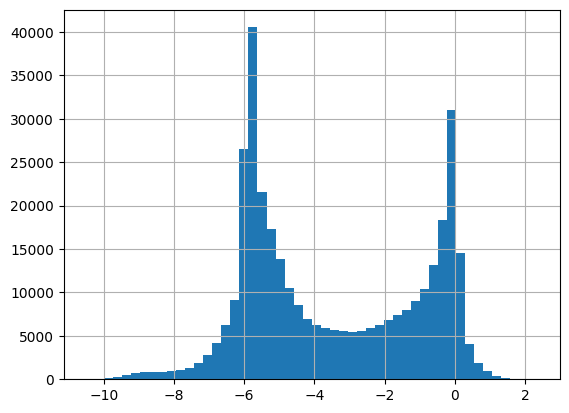

In [141]:
df.func_score.hist(bins=50)

In [142]:
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,S12F P43F,observed_phenotype,-0.338826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,2.696775,2
1,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
2,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
3,lib_1,h1,N22W L49I,observed_phenotype,-5.121204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.817175,2
4,lib_1,h1,K21N,observed_phenotype,-0.032459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,4.402149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349861,lib_2,h2,T4C N22A E28V,tight_bottle,-0.872689,pre-selection,0.225674,17.0,19.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.016912,3
349862,lib_2,h2,L2S A10S E28L,tight_bottle,-0.428415,pre-selection,0.222853,15.0,23.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,0.329871,3
349863,lib_2,h2,T4H D18S,tight_bottle,-1.590687,pre-selection,0.332509,15.0,10.0,1631741.0,3329303.0,0.5,2.0,>1 nonsynonymous,0.215730,2
349864,lib_2,h2,T12P A20I V41E,tight_bottle,-3.564861,pre-selection,0.976092,14.0,2.0,1631741.0,3329303.0,0.5,3.0,>1 nonsynonymous,-1.403989,3


In [143]:
df.query(f"replicate == '{replicate}' & func_score_type == '{func_score_type}'", inplace=True)
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
174868,lib_1,h1,S5I G7R F34A,tight_bottle,0.103489,pre-selection,0.003460,907.0,1787.0,1508174.0,2765016.0,0.5,3.0,>1 nonsynonymous,3.625038,3
174869,lib_1,h1,V15G,tight_bottle,-2.059319,pre-selection,0.001421,4802.0,2112.0,1508174.0,2765016.0,0.5,1.0,1 nonsynonymous,0.514604,1
174870,lib_1,h1,S12F V41G,tight_bottle,0.203226,pre-selection,0.003927,781.0,1649.0,1508174.0,2765016.0,0.5,2.0,>1 nonsynonymous,4.254342,2
174871,lib_1,h1,M29S,tight_bottle,-0.308485,pre-selection,0.000556,6292.0,9315.0,1508174.0,2765016.0,0.5,1.0,1 nonsynonymous,4.426295,1
174872,lib_1,h1,,tight_bottle,0.000000,pre-selection,0.000004,1508174.0,2765016.0,1508174.0,2765016.0,0.5,0.0,wildtype,5.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320775,lib_1,h2,D9L V26L,tight_bottle,-1.108689,pre-selection,0.181076,23.0,22.0,1575383.0,3252741.0,0.5,2.0,>1 nonsynonymous,0.429055,2
320776,lib_1,h2,D9N F19G,tight_bottle,-6.537806,pre-selection,4.255245,22.0,0.0,1575383.0,3252741.0,0.5,2.0,>1 nonsynonymous,-4.524388,2
320777,lib_1,h2,V15A A20G,tight_bottle,0.803907,pre-selection,0.123666,21.0,77.0,1575383.0,3252741.0,0.5,2.0,>1 nonsynonymous,3.004933,2
320778,lib_1,h2,R13V E28L V41I V42T,tight_bottle,-6.331355,pre-selection,4.269477,19.0,0.0,1575383.0,3252741.0,0.5,4.0,>1 nonsynonymous,-11.277482,4


In [144]:

# remove variants with too many deletions
df = df.loc[df.aa_substitutions.str.count("-") == 0, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,1508174.0,2765016.0,0.000000
1,h1,lib_1,A10*,1,2510.0,65.0,-6.134821
2,h1,lib_1,A10* C26K E27I M29R S46I,5,187.0,8.0,-5.337769
3,h1,lib_1,A10* C26L,2,155.0,0.0,-9.155255
4,h1,lib_1,A10* C26P W40T P43F,4,389.0,6.0,-6.779525
...,...,...,...,...,...,...,...
58475,h2,lib_1,Y47T G48S,2,167.0,5.0,-5.974539
58476,h2,lib_1,Y47T L49E,2,383.0,21.0,-5.202771
58477,h2,lib_1,Y47V,1,6231.0,14637.0,0.186065
58478,h2,lib_1,Y47V E50R,2,193.0,517.0,0.373272


In [145]:
df.query("aa_substitutions == ''")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,1508174.0,2765016.0,0.0
29190,h2,lib_1,,0,1575383.0,3252741.0,0.0


In [146]:
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score


Ah, G50W doesn't hit the threshold.

### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

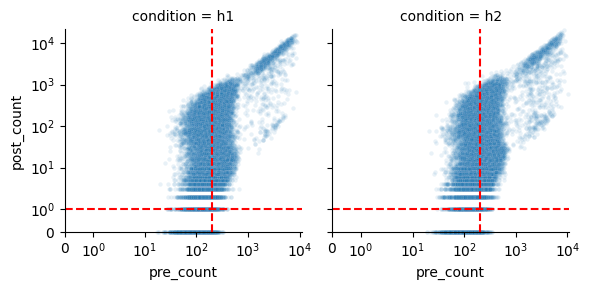

In [147]:
if func_score_type != "observed_phenotype":
    g = sns.relplot(
        x=df.pre_count[df.aa_substitutions != ""],
        y=df.post_count[df.aa_substitutions != ""],
        col=df.condition[df.aa_substitutions != ""],
        s=10, alpha=0.1,
        height=3, aspect=1,
        clip_on=False,
        )
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xscale("symlog", linthresh=1, linscale=0.5)
    plt.yscale("symlog", linthresh=1, linscale=0.5)

    for ax in g.axes.flat:
        condition = ax.get_title().split(" = ")[1]
        df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
        df.drop(index=df_condition.query("(pre_count < @min_pre_count) | (post_count < @min_post_count)").index, inplace=True)
        ax.axvline(min_pre_count, color="red", linestyle="--")
        ax.axhline(min_post_count, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

In [148]:
df.shape

(29775, 7)

### Mutation number filtering

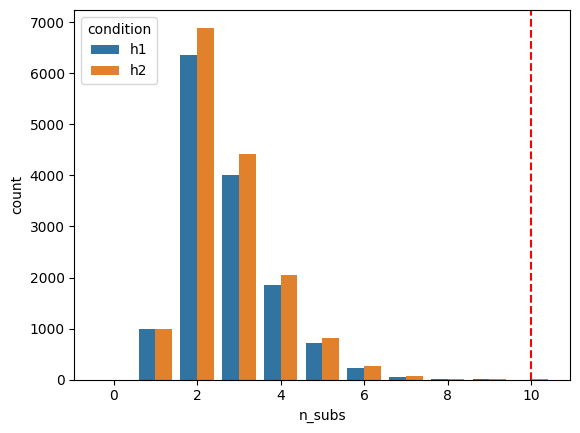

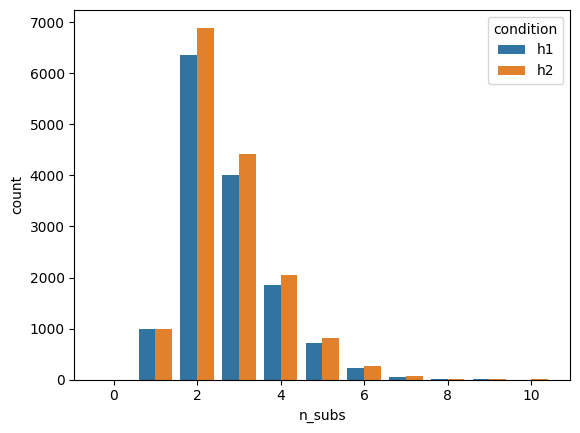

In [149]:
n_sub_thresh = 10

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.axvline(n_sub_thresh, color="red", linestyle="--")
plt.show()

df = df.query("n_subs <= @n_sub_thresh")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


In [150]:
df.shape

(29775, 7)

### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [151]:
# # TEMP: cmopletetely remove nonsense
# df = df.loc[~df.aa_substitutions.str.contains("*", regex=False)]
# df.shape

In [152]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

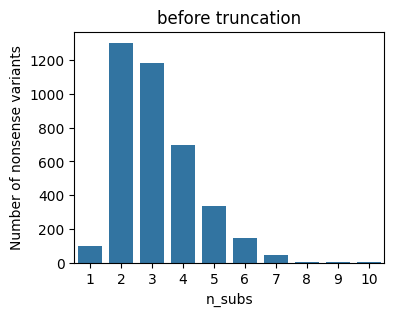

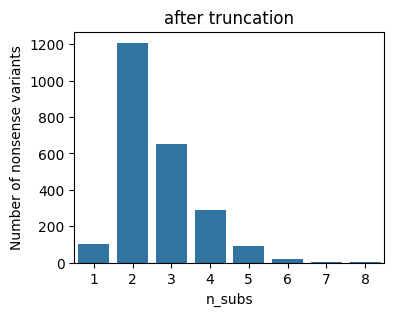

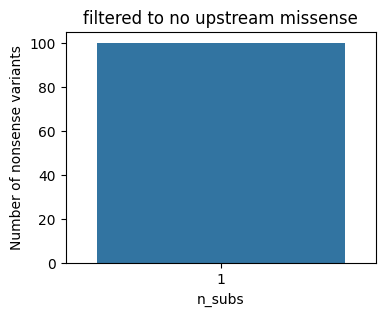

In [153]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_82126/702988830.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)


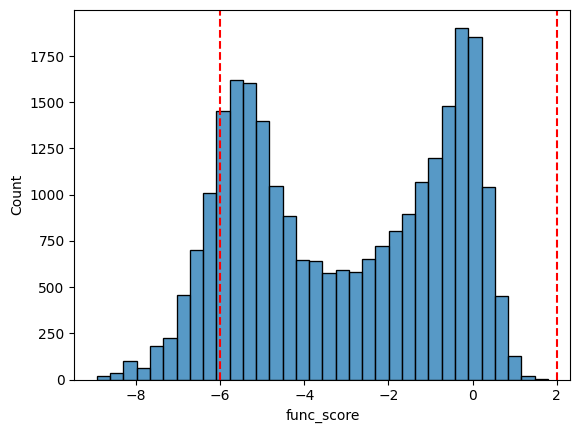

In [154]:
# df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

# def group_wt_ref(df_group):
#     wts = df_group.query("aa_substitutions == ''")
#     assert wts.shape[0] == 1, wts
#     df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
#     return df_group

# df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

sns.histplot(df.func_score)
plt.axvline(functional_score_min, color="red", linestyle="--")
plt.axvline(functional_score_max, color="red", linestyle="--")
df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)
plt.show()

<Axes: xlabel='func_score', ylabel='Count'>

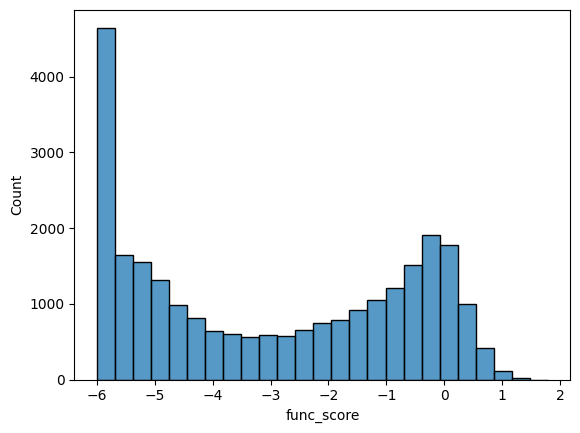

In [155]:
sns.histplot(df.func_score)

### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [156]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

/Users/macdre/Matsengrp/projects/dms/.pixi/envs/default/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Create a `jaxmodels.Data` object, containing the array data

In [157]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[1000],
  X=BCOO(int8[12494, 1000], nse=33144),
  functional_scores=f64[12494],
  pre_count_wt=f64[],
  post_count_wt=f64[],
  pre_counts=f64[12494],
  post_counts=f64[12494]
)

In [158]:
data_sets

{'h1': Data(
   x_wt=i8[1000],
   X=BCOO(int8[12494, 1000], nse=33144),
   functional_scores=f64[12494],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[12494],
   post_counts=f64[12494]
 ),
 'h2': Data(
   x_wt=i8[1000],
   X=BCOO(int8[13560, 1000], nse=164070),
   functional_scores=f64[13560],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[13560],
   post_counts=f64[13560]
 )}

In [159]:
df.query("aa_substitutions == ''    ")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,1508174.0,2765016.0,0.0
13560,h2,lib_1,,0,1575383.0,3252741.0,0.0


In [160]:
for condition in multidms_data.conditions:
    print(data_sets[condition].pre_count_wt)
    print(data_sets[condition].post_count_wt)


1508174.0
2765016.0
1575383.0
3252741.0


In [161]:
{d: int(data_sets[d].x_wt.sum()) for d in data_sets}

{'h1': 0, 'h2': 10}

Plot the sums of the binary encodings of the variants

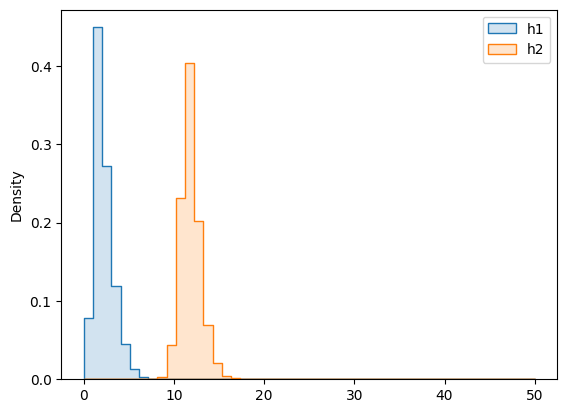

In [162]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

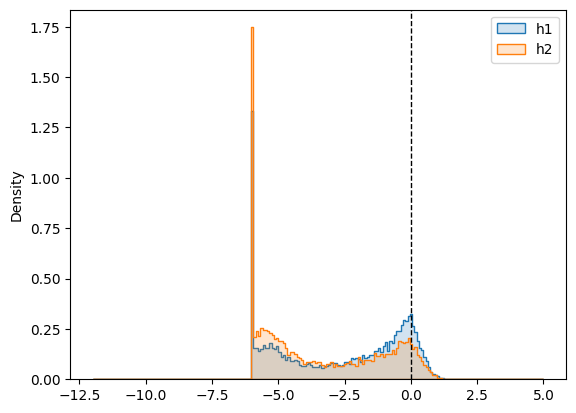

In [163]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [164]:
model, loss_trajectory = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    loss_kwargs=loss_kwargs,
    warmstart=warmstart,
    beta_naught_init=beta_naught_init,
    beta_clip_range=beta_clip,
    alpha_init=alpha_init,
    beta0_ridge=beta0_ridge
    )

iter 1:
  calibration block: error=0.00e+00, stepsize=2.0e+00, iter=1
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
  β0 block: error=0.00e+00, stepsize=2.0e+00, iter=1
    h1: β0=0.00
    h2: β0=0.00
  β_nonbundle: error=2.33e-06, stepsize=4.1e+03, iter=1000
  β_bundle: error=6.10e-06, stepsize=8.0e+00, iter=1000
  h2 sparsity=51.0%
  obj=2.46e-01
  objective_error=7.54e-01
iter 2:
  calibration block: error=2.21e-05, stepsize=1.3e+02, iter=21
    h1: α=9.62, θ=1.00
    h2: α=6.55, θ=1.00
  β0 block: error=2.19e-07, stepsize=1.6e+01, iter=28
    h1: β0=0.11
    h2: β0=-0.22
  β_nonbundle: error=7.22e-04, stepsize=2.6e+02, iter=1000
  β_bundle: error=9.70e-07, stepsize=1.6e+01, iter=797
  h2 sparsity=27.8%
  obj=1.49e-01
  objective_error=9.65e-02
iter 3:
  calibration block: error=3.23e-05, stepsize=6.4e+01, iter=13
    h1: α=10.42, θ=1.00
    h2: α=6.85, θ=1.00
  β0 block: error=7.99e-07, stepsize=1.6e+01, iter=19
    h1: β0=0.17
    h2: β0=-0.28
  β_nonbundle: error=2.22e-04, stepsi

## Loss trajectory

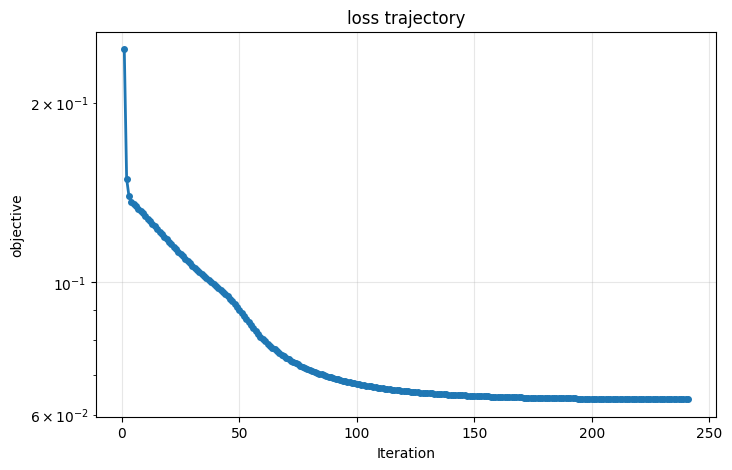

Final loss: 0.063736
Total iterations: 241


In [165]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_trajectory) + 1), loss_trajectory, 'o-', linewidth=2, markersize=4)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title('loss trajectory')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_trajectory[-1]:.6f}")
print(f"Total iterations: {len(loss_trajectory)}")


$\beta$ shift distributions

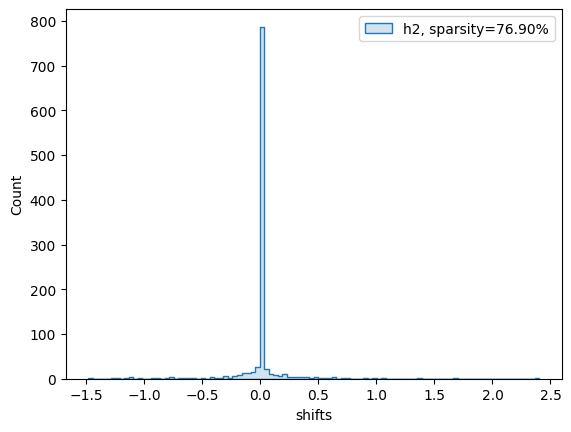

In [166]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            bins=100,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Read in ground truth mut effects

In [167]:
simu_mut_effects = pd.read_csv("../scaled_down_parameter_output/simulated_muteffects.csv", keep_default_na=False)
simu_mut_effects

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


Find ground truth sparsity

In [168]:
# how many shifts are equal to zero in simulated mut effects
zero_shift_df = simu_mut_effects[simu_mut_effects["shift"] == 0]
display(zero_shift_df)
(zero_shift_df.shape[0], simu_mut_effects.shape[0], zero_shift_df.shape[0] / simu_mut_effects.shape[0])

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


(810, 1000, 0.81)

Functional score correlations

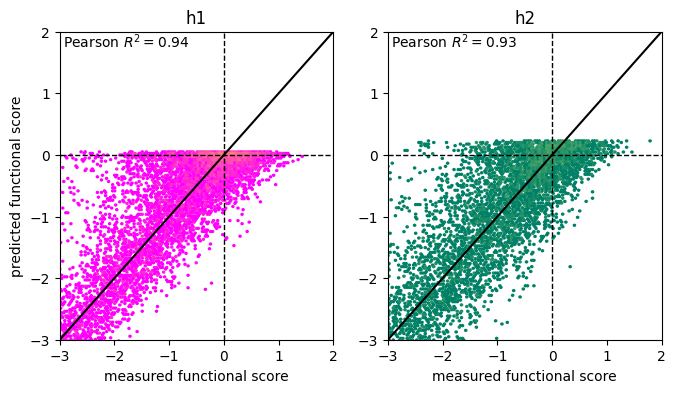

In [169]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $R^2={scipy.stats.pearsonr(y, y_pred).statistic**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-3, 2)
    plt.ylim(-3, 2)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

In [170]:
data_sets["h2"].x_wt.sum()

Array(10, dtype=int64)

In [171]:
model.φ["h2"]

Latent(β0=f64[], β=f64[1000])

In [172]:
(model.φ["h2"].β * data_sets["h2"].x_wt).sum() 

Array(-1.43865267, dtype=float64)

In [173]:
model.φ["h2"].β0

Array(4.64646289, dtype=float64)

h1 4.726828639098151
h2 3.2078102228005982


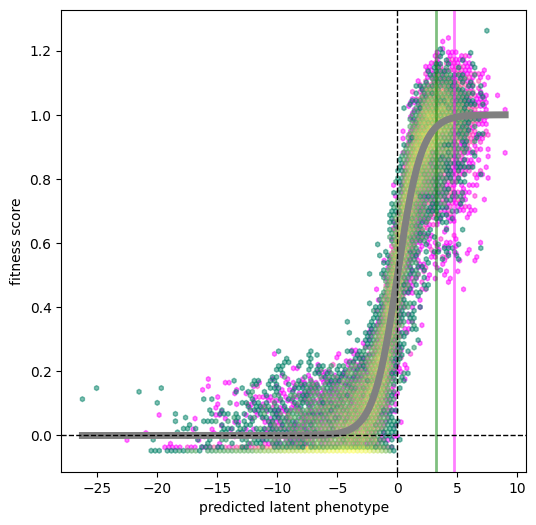

In [174]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
# plot the global epistasis function

for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    print(d, φ_pred_wt)
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=100, alpha=0.5)

φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
# plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

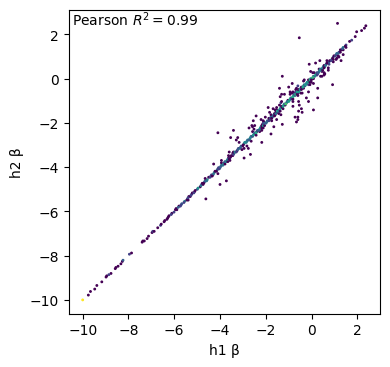

In [175]:
plt.figure(figsize=(4, 7))


plt.subplot(211)
plt.hexbin(model.φ["h1"].β, model.φ["h2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["h1"].β, model.φ["h2"].β).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("h1 β")
plt.ylabel("h2 β")

plt.tight_layout()
plt.show()

In [176]:
model.α

{'h1': Array(5.83648049, dtype=float64),
 'h2': Array(5.94884849, dtype=float64)}

Distribution of $\beta$

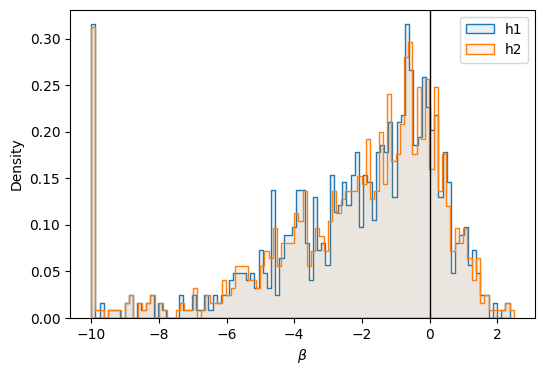

In [177]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [178]:
mutations_df = multidms_data.mutations_df
mutations_df

,mutation,wts,sites,muts,times_seen_h1,times_seen_h2
0,F1A,F,1,A,31,38
1,F1C,F,1,C,14,19
2,F1D,F,1,D,26,31
3,F1E,F,1,E,29,29
4,F1G,F,1,G,41,47
...,...,...,...,...,...,...
995,E50T,E,50,T,53,58
996,E50V,E,50,V,46,50
997,E50W,E,50,W,11,13
998,E50Y,E,50,Y,20,21


In [179]:
len(multidms_data.mutations), data_sets["h1"].X.shape

(1000, (12494, 1000))

In [180]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    if d != multidms_data.reference:
        mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

# mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df = (
    mutations_df
    .drop(["wts", "sites", "muts"], axis=1)
    .set_index("mutation")
)
mutations_df

,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,
F1A,31,38,-1.924991,-1.924991,0.000000
F1C,14,19,-0.592777,-0.592777,0.000000
F1D,26,31,-2.771321,-2.771321,0.000000
F1E,29,29,-1.313930,-1.313930,0.000000
F1G,41,47,-4.648352,-4.522607,0.125745
...,...,...,...,...,...
E50T,53,58,-1.010983,-0.968270,0.042713
E50V,46,50,-0.871528,-0.933470,-0.061942
E50W,11,13,-1.257268,-1.257268,0.000000


In [181]:
mutations_df.beta_h1.isna().sum()

np.int64(0)

In [182]:
simu_mut_effects = (
    simu_mut_effects
    .drop(["wt_aa", "site", "mut_aa"], axis=1)
    .set_index("mutation")
    .rename(
        columns={
            "shift": "simulated_shift",
            "beta_h1": "simulated_beta_h1",
            "beta_h2": "simulated_beta_h2"
        }
    )
)
simu_mut_effects

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
mutation,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False
F1C,-0.417888,False,0.0,-0.417888,F,F,False
F1D,-2.928096,False,0.0,-2.928096,F,F,False
F1E,-1.516192,False,0.0,-1.516192,F,F,False
F1G,-4.732575,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False
E50V,-0.989250,False,0.0,-0.989250,E,E,False
E50W,-1.192453,False,0.0,-1.192453,E,E,False


In [183]:
simu_mut_effects.shape

(1000, 7)

In [184]:
set(simu_mut_effects.index.values) - set(mutations_df.index.values)

set()

In [185]:
# merge the simulated mut effects with the inferred mut effects
merged_df = simu_mut_effects.join(mutations_df, how="inner")
merged_df

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False,31,38,-1.924991,-1.924991,0.000000
F1C,-0.417888,False,0.0,-0.417888,F,F,False,14,19,-0.592777,-0.592777,0.000000
F1D,-2.928096,False,0.0,-2.928096,F,F,False,26,31,-2.771321,-2.771321,0.000000
F1E,-1.516192,False,0.0,-1.516192,F,F,False,29,29,-1.313930,-1.313930,0.000000
F1G,-4.732575,False,0.0,-4.732575,F,F,False,41,47,-4.648352,-4.522607,0.125745
...,...,...,...,...,...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False,53,58,-1.010983,-0.968270,0.042713
E50V,-0.989250,False,0.0,-0.989250,E,E,False,46,50,-0.871528,-0.933470,-0.061942
E50W,-1.192453,False,0.0,-1.192453,E,E,False,11,13,-1.257268,-1.257268,0.000000


In [186]:
merged_df.shape

(1000, 12)

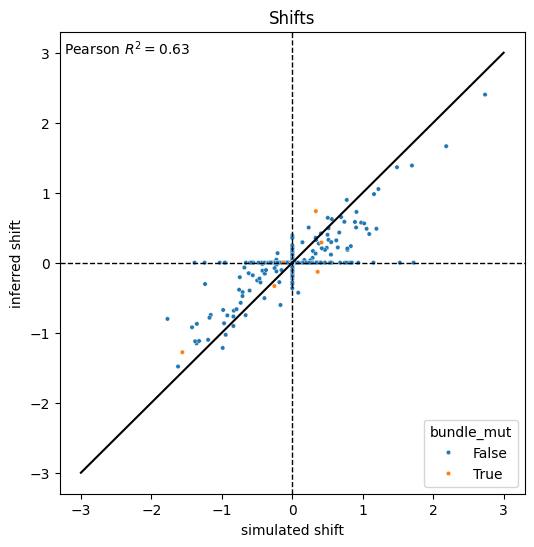

In [187]:
# plot inferred shifts vs simulated shifts for h2

plt.figure(figsize=(6, 6))
x = merged_df['simulated_shift']#.query("mutation.str.contains('19')")["simulated_shift"]
y = merged_df['shift_h2']#.query("mutation.str.contains('19')")["shift_h2"]
# plt.scatter(x, y, alpha=1, s=10)
plt.plot([-3, 3], [-3, 3], "k")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
sns.scatterplot(
    merged_df,#.query("mutation.str.contains('19')"), 
    x="simulated_shift", 
    y="shift_h2", 
    alpha=1, 
    s=10,
    hue="bundle_mut"
    )
r = scipy.stats.pearsonr(x, y).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                fontsize=10,
                xy=(0.01, 0.95), xycoords="axes fraction")
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.xlabel("simulated shift")
plt.ylabel("inferred shift")
plt.title("Shifts")
plt.show()

In [188]:
merged_df = merged_df.assign(shift_error_h2 = (merged_df["simulated_shift"] - merged_df["shift_h2"]))
merged_df.query("bundle_mut")["shift_error_h2"].sum()

np.float64(-0.029211049853394344)

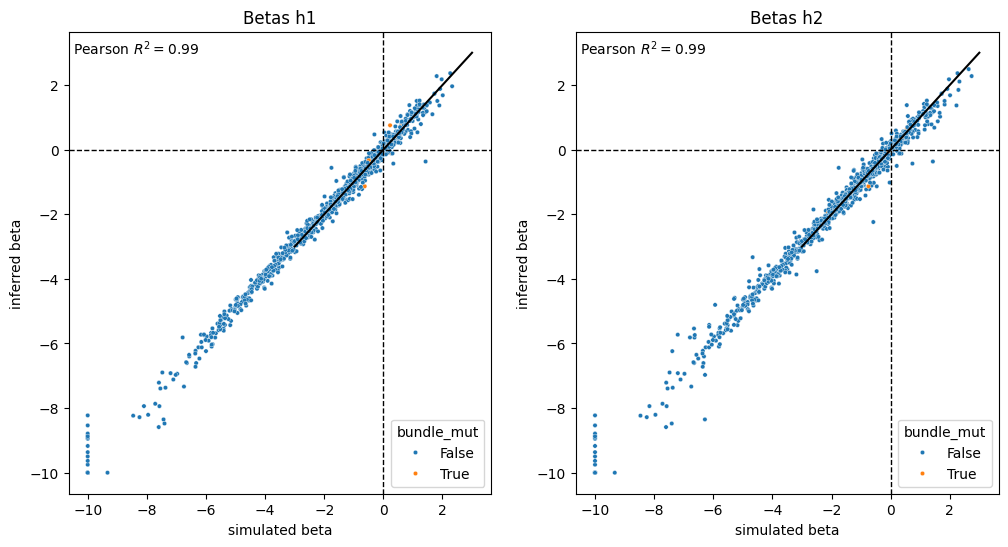

In [189]:
# plot inferred betas vs simulated betas for both h1 and h2
plt.figure(figsize=(12, 6))
for i, d in enumerate(["h1", "h2"]):
    plt.subplot(1, 2, i + 1)
    x = merged_df[f"simulated_beta_{d}"]
    y = merged_df[f"beta_{d}"]
    # plt.scatter(x, y, alpha=1, s=10)
    sns.scatterplot(merged_df, x=f"simulated_beta_{d}", y=f"beta_{d}", alpha=1, s=10, hue="bundle_mut")
    r = scipy.stats.pearsonr(x, y).statistic
    plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-3, 3], [-3, 3], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    # plt.xlim(-3, 3)
    # plt.ylim(-3, 3)
    plt.xlabel("simulated beta")
    plt.ylabel("inferred beta")
    plt.title(f"Betas {d}")

In [190]:
merged_df = merged_df.assign(abs_beta_error_h2 = (merged_df["simulated_beta_h2"] - merged_df["beta_h2"]).abs())
merged_df.sort_values("abs_beta_error_h2", ascending=False)

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2,shift_error_h2,abs_beta_error_h2
mutation,,,,,,,,,,,,,,
A9H,-7.435186,True,1.152969,-6.282217,A,D,False,20,22,-8.350054,-8.350054,0.0,1.152969,2.067837
D11W,1.429619,False,0.000000,1.429619,D,D,False,11,10,-0.367680,-0.367680,0.0,0.000000,1.797299
Y42*,-10.000000,False,0.000000,-10.000000,Y,V,False,1,1,-8.225101,-8.225101,0.0,0.000000,1.774899
R19M,-2.307920,True,1.721806,-0.586114,R,F,False,11,11,-2.239808,-2.239808,0.0,1.721806,1.653694
H31M,-6.170295,True,-1.030085,-7.200381,H,C,False,8,11,-5.727727,-5.727727,0.0,-1.030085,1.472654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W40*,-10.000000,False,0.000000,-10.000000,W,W,False,1,1,-10.000000,-10.000000,0.0,0.000000,0.000000
M29*,-10.000000,False,0.000000,-10.000000,M,M,False,1,1,-10.000000,-10.000000,0.0,0.000000,0.000000
L2*,-10.000000,False,0.000000,-10.000000,L,L,False,1,1,-10.000000,-10.000000,0.0,0.000000,0.000000
